# Análisis y procesamiento de salidas del radar meteorológico RMA0

### 1. Librerias necesarias

In [1]:

# Este comando \\\"limpia\\\" todas las variables definidas (equivalente a clear all de Matlab)
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro de la misma Notebook, no en una ventana
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import glob
import pyart
import scipy.io as sio



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### 2. Lectura de datos

In [2]:

path_data = '/data1/Dropbox/02_TRABAJO/Proyectos_SMN/15_Proyecto_QC_radar/calibracion_ZDR/data/RMA1/'

FileList = np.sort(glob.glob(path_data+'*.nc'))

file2read = FileList[3]
print(file2read)


/data1/Dropbox/02_TRABAJO/Proyectos_SMN/15_Proyecto_QC_radar/calibracion_ZDR/data/RMA1/cfrad.20180113_163711.0000_to_20180113_164300.0000_RMA1_0201_01.nc


In [3]:

# Creamos el objeto "radar"
radar = pyart.io.read(file2read)

# ¿Con qué variables contamos en el archivo?
print('--------------------------------------------------------------')
print('Variables contenidas en el archivo:')
print(radar.fields.keys())

# ¿Cuales son las elevaciones (PPI) que componen este volumen?
print('--------------------------------------------------------------')
print('Elevaciones (PPI) que conforman el volumen escaneado:')
print(radar.fixed_angle['data'])

# ¿Cuál es el rango máximo (km) de los datos contenidos en este volumen?
print('--------------------------------------------------------------')
print('Rango máximo (km) del volumen escaneado:')
print(radar.range['data'][-1]*0.001)
print('--------------------------------------------------------------')


--------------------------------------------------------------
Variables contenidas en el archivo:
dict_keys(['PHIDP', 'CM', 'RHOHV', 'TH', 'TV', 'KDP'])
--------------------------------------------------------------
Elevaciones (PPI) que conforman el volumen escaneado:
[  0.52999997   0.88         1.32000005   1.79999995   2.28999996
   3.07999992   4.           5.0999999    6.36999989   7.94999981
   9.93000031  12.43999958  15.51000023  19.90999985  29.96999931]
--------------------------------------------------------------
Rango máximo (km) del volumen escaneado:
237.99
--------------------------------------------------------------


### 3. Visualización B-scope

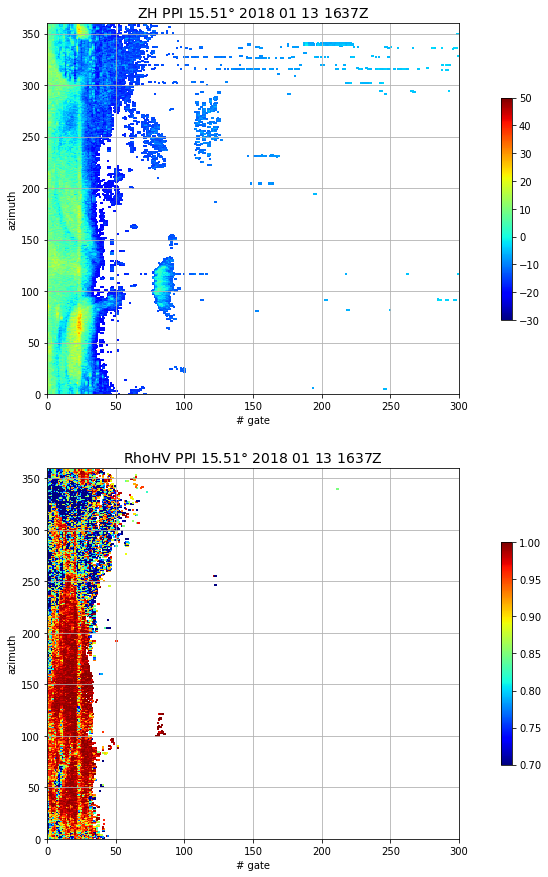

In [10]:

sweep=12

minlat = radar.latitude['data'][0]  - 2.0
maxlat = radar.latitude['data'][0]  + 2.0
minlon = radar.longitude['data'][0] - 3.0
maxlon = radar.longitude['data'][0] + 3.0

radarlat = radar.latitude['data'][0]
radarlon = radar.longitude['data'][0]

inicio = radar.sweep_start_ray_index['data'][sweep]
final  = radar.sweep_end_ray_index['data'][sweep]

anio = radar.time['units'][14:18]
mes  = radar.time['units'][19:21]
dia  = radar.time['units'][22:24]
hora = radar.time['units'][25:27] + radar.time['units'][28:30]
elev = radar.elevation['data'][0]

radar.fields['TH']['standard_name'] = u'ZH'
radar.fields['TH']['units'] = u'dBZ'

radar.fields['RHOHV']['standard_name'] = u'RhoHV'

#=========================================================================================#

fig = plt.figure(figsize = [15,15])

fig.add_subplot(211,aspect=0.75)
plt.pcolormesh(radar.fields['TH']['data'][inicio:final], cmap='jet',vmin=-30.0, vmax=50.0)
plt.colorbar(shrink=0.6)
#plt.contour(radar.fields['RHOHV']['data'][inicio:final], [0.95], linewidths=2.0,colors='k')
plt.xlim([0,300])
plt.ylim([0,360])
plt.xlabel('# gate')
plt.ylabel('azimuth')
plt.grid()
plt.title(radar.fields['TH']['standard_name'] + ' PPI '+ str(radar.elevation['data'][(361*sweep)+1]) + r'${\degree}$ ' +
          anio + ' ' + mes + ' ' + dia + ' ' + hora + 'Z', fontsize=14);


fig.add_subplot(212,aspect=0.75)
plt.pcolormesh(radar.fields['RHOHV']['data'][inicio:final],cmap='jet', vmin=0.7, vmax=1.0)
plt.colorbar(shrink=0.6)
plt.xlim([0,300])
plt.ylim([0,360])
plt.xlabel('# gate')
plt.ylabel('azimuth')
plt.grid()
plt.title(radar.fields['RHOHV']['standard_name'] + ' PPI '+ str(radar.elevation['data'][(361*sweep)+1]) + r'${\degree}$ ' +
          anio + ' ' + mes + ' ' + dia + ' ' + hora + 'Z', fontsize=14);

#plt.savefig('RMA0_20150619T1932Z_20deg.png',dpi=100,transparent=False)

plt.show()


/home/lvidal/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  del sys.path[0]


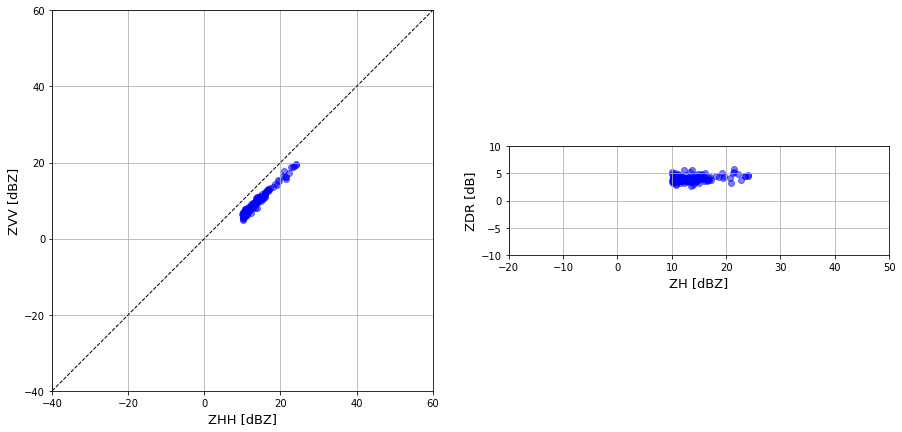

4.06043439593 0.555208394563


In [11]:

sweep=12

inicio=radar.sweep_start_ray_index['data'][sweep]
final=radar.sweep_end_ray_index['data'][sweep]

ZH  = radar.fields['TH']['data'][inicio:final]
ZV  = radar.fields['TV']['data'][inicio:final]
RHO = radar.fields['RHOHV']['data'][inicio:final]

#===============================================================================================#

RHO[RHO>1.0]=1.0
ZHthr=10.0
ZVthr=10.0
Rangethr_min=25
Rangethr_max=1000

# ACA PONGO CONDICION SOBRE EL RHOHV
#RhoHVthr=0.95 # Umbral propuesto por Trabal et al. (2014)
#ZHrec  = np.extract(RHO>RhoHVthr,ZH)
#ZVrec  = np.extract(RHO>RhoHVthr,ZV)
#RHOrec = np.extract(RHO>RhoHVthr,RHO)

# FALTA PONER UNA CONDICION DE ALTURA, PARA TOMAR PIXELES POR ENCIMA DE LA BANDA BRILLANTE

ZHrec = radar.fields['TH']['data'][inicio:final,Rangethr_min:Rangethr_max]
ZVrec = radar.fields['TV']['data'][inicio:final,Rangethr_min:Rangethr_max]

ZHrecrec = np.extract(ZHrec>ZHthr,ZHrec)
ZVrecrec = np.extract(ZHrec>ZHthr,ZVrec)

#===============================================================================================#

fig = plt.figure(figsize = [15,10])

fig.add_subplot(121,aspect=1)
plt.scatter(ZHrecrec, ZVrecrec, color='b', marker='o', alpha=0.5)
plt.xlim([-40,60])
plt.ylim([-40,60])
plt.xlabel('ZHH [dBZ]',fontsize=13)
plt.ylabel('ZVV [dBZ]',fontsize=13)
plt.plot((-40, 60), (-40, 60), linewidth=1.0, color='k', linestyle='--')
plt.grid()

fig.add_subplot(122,aspect=1)
plt.scatter(ZHrecrec, ZHrecrec-ZVrecrec, color='b', marker='o', alpha=0.5)
plt.xlim([-20,50])
plt.ylim([-10,10])
plt.xlabel('ZH [dBZ]',fontsize=13)
plt.ylabel('ZDR [dB]',fontsize=13)
#plt.plot((-30, 60), (-30, 60), linewidth=1.0, color='k', linestyle='--')
plt.grid()

plt.show()

mean=np.mean(ZHrecrec-ZVrecrec)
std=np.std(ZHrecrec-ZVrecrec)
print(mean,std)


### Calculo de offset de Zdr

In [ ]:

# Este comando "limpia" todas las variables definidas (equivalente a clear all de Matlab)
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro de la misma Notebook, no en una ventana
%matplotlib inline

import glob
import numpy as np
import matplotlib.pyplot as plt
import pyart
import matplotlib

path_user = '/data1/Dropbox/02_TRABAJO/Proyectos_SMN/15_Proyecto_QC_radar/calibracion_ZDR/data/RMA1/'
files = np.sort(glob.glob(path_user+'*01.nc'))

sweep=7

RhoHVthr=0.95 # Umbral propuesto por Trabal et al. (2014)

output = np.empty([len(files), 7])

for i in range(len(files)):
    
    file2read=files[i]
    print(file2read)
    
    radar = pyart.io.read(file2read)
    
    inicio=radar.sweep_start_ray_index['data'][sweep]
    final=radar.sweep_end_ray_index['data'][sweep]

    ZH  = radar.fields['TH']['data'][inicio:final]
    ZV  = radar.fields['TV']['data'][inicio:final]
    RHO = radar.fields['RHOHV']['data'][inicio:final]
    RHO[RHO>1.0]=1.0
    
    ZHrec  = np.extract(RHO>RhoHVthr,ZH)
    ZVrec  = np.extract(RHO>RhoHVthr,ZV)
    RHOrec = np.extract(RHO>RhoHVthr,RHO)
    
    output[i,0] = radar.time['units'][14:18] # Año
    output[i,1] = radar.time['units'][19:21] # Mes
    output[i,2] = radar.time['units'][22:24] # Dia
    output[i,3] = radar.time['units'][25:27] # Hora
    output[i,4] = radar.time['units'][28:30] # Minutos
    
    output[i,5]=np.mean(ZHrec-ZVrec)
    output[i,6]=np.std(ZHrec-ZVrec)

print('Termino de procesar!!!!')


In [ ]:
mean_zdr = np.mean(output[:,5])
std_zdr  = np.std(output[:,6])

fig = plt.figure(figsize = [10,5])

plt.plot(output[:,5],'bo')

plt.xlim([-1, 15])
plt.ylim([3.6, 4.6])

plt.title('November 2, 2017',fontsize=16)
plt.xlabel('UTC Time [h]',fontsize=14)
plt.ylabel('Mean ZDR [dB]',fontsize=14)

plt.plot((0, 12), (mean_zdr, mean_zdr), linewidth=2.0, color='r', linestyle='-')

plt.annotate('Mean: '+ str(mean_zdr) + 'dB', xy=(-0.7, 4.5),fontsize=14)
plt.annotate('SD: ' + str(std_zdr) + 'dB', xy=(-0.7, 4.43),fontsize=14)

plt.grid()

#plt.savefig('RMA0_20150619_4003_01_20deg.png',dpi=100,transparent=False)

plt.show()

In [ ]:
import datetime

datetime.datetime(int(output[0,0]),int(output[0,1]),int(output[0,2]),int(output[0,3]),int(output[0,4]))

# Alternativa usando listas

In [ ]:
path_user = './data/20150619/4003_01/'
files = np.sort(glob.glob(path_user+'*.nc'))

sweep=7

RhoHVthr=0.95 # Umbral propuesto por Trabal et al. (2014)

output = np.empty([13, 2])
time = []

for i in range(13):
    
    file2read=files[i]
    print(file2read)
    
    radar = pyart.io.read(file2read)
    
    inicio=radar.sweep_start_ray_index['data'][sweep]
    final=radar.sweep_end_ray_index['data'][sweep]

    ZH  = radar.fields['TH']['data'][inicio:final]
    ZV  = radar.fields['TV']['data'][inicio:final]
    RHO = radar.fields['RHOHV']['data'][inicio:final]
    RHO[RHO>1.0]=1.0
    
    ZHrec  = np.extract(RHO>RhoHVthr,ZH)
    ZVrec  = np.extract(RHO>RhoHVthr,ZV)
    RHOrec = np.extract(RHO>RhoHVthr,RHO)
    
    print(ZHrec.shape)
    
    year=int(radar.time['units'][14:18])
    month=int(radar.time['units'][19:21]) # Mes
    day=int(radar.time['units'][22:24]) # Dia
    hour=int(radar.time['units'][25:27]) # Hora
    minute=int(radar.time['units'][28:30]) # Minutos
    time.append(datetime.datetime(year,month,day,hour,minute))
    
    output[i,0]=np.mean(ZHrec-ZVrec)
    output[i,1]=np.std(ZHrec-ZVrec)

print('Termino de procesar!!!!')

In [ ]:
import matplotlib.dates as mdates

datetime_inicial=datetime.datetime(2015, 6, 19, 17, 9)
datetime_final=datetime.datetime(2015, 6, 19, 19, 42)

# Edito el formato de la hora (va a ir al eje x)
minutos_mdates = mdates.MinuteLocator(interval=9)
horas_mdates = mdates.HourLocator()
horasfmt = mdates.DateFormatter('%H:%M')


mean_zdr = np.mean(output[:,0])
std_zdr  = np.std(output[:,1])

#=====================================================================================================#

fig, ax = plt.subplots(figsize = [10,5])

#plt.plot(time,output[:,0],'bo')

plt.errorbar(time, output[:,0], output[:,1], linestyle='None', marker='o')

plt.title('June 19, 2015',fontsize=16)
plt.xlabel('UTC Time [h]',fontsize=14)
plt.ylabel('Mean ZDR [dB]',fontsize=14)

plt.plot((time[0], time[-1]), (mean_zdr, mean_zdr), linewidth=2.0, color='r', linestyle='-')

plt.annotate('Mean: '+ str(mean_zdr) + 'dB', xy=(-0.7, 4.475),fontsize=14)
plt.annotate('SD: ' + str(std_zdr) + 'dB', xy=(-0.7, 4.460),fontsize=14)

plt.grid()

# Le digo en que formato poner la hora en el eje x
ax.xaxis.set_major_locator(horas_mdates)
ax.xaxis.set_major_formatter(horasfmt)

ax.xaxis.set_major_locator(minutos_mdates)

ax.set_ylim([3.5, 5.5])
ax.set_xlim(datetime_inicial, datetime_final)

fig.autofmt_xdate()

plt.annotate('Mean: 4.58 dB', xy=(datetime.datetime(2015,6,19,17,12), 3.75),fontsize=14)
plt.annotate('# of samples: 258310', xy=(datetime.datetime(2015,6,19,17,12), 3.6),fontsize=14)

plt.savefig('RMA0_20150619_4003_01_20deg.png',dpi=100,transparent=False)

plt.show()